In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import feature_engineering as fe
import tuning as tm
import visualize as vz

In [2]:
from pathlib import Path

In [3]:
#install XGBoost
import sys
!{sys.executable} -m pip install xgboost

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

# Define Dictifier class to turn df into dictionary as part of pipeline
class Dictifier(BaseEstimator, TransformerMixin):       
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if type(X) == pd.core.frame.DataFrame:
            return X.to_dict("records")
        else:
            return pd.DataFrame(X).to_dict("records")

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
pipeline = Pipeline([
    #("featureunion", numeric_categorical_union),
    ("dictifier", Dictifier()),
    ('ohe_onestep', DictVectorizer(sparse=False)),
    ("clf", xgb.XGBClassifier(max_depth=3))
])

pre-process dataset for training

In [6]:
 #data from UCI: https://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification#
df = pd.read_csv("MiniBooNE.csv") 
df.rename(columns = {'51':'signal'}, inplace = True) #1: electron neutrino, 0: muon neutrino (background)

In [7]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,signal
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1


In [8]:
vz.pretty_describe(df)

,count,mean,std,min,10%,25%,50%,75%,90%,max
1,"130,064.000",1.252,60.120,-999.000,3.358,4.013,4.788,5.628,6.386,17.057
2,"130,064.000",-2.108,59.913,-999.000,0.489,0.876,1.382,1.948,2.511,8.803
3,"130,064.000",123.795,196.011,-999.000,16.770,49.295,106.136,138.849,196.829,"4,747.670"
4,"130,064.000",-3.313,59.835,-999.000,0.219,0.242,0.272,0.315,0.362,0.737
5,"130,064.000",-3.585,59.818,-999.000,0.000,0.000,0.005,0.013,0.025,0.179
6,"130,064.000",-3.434,59.827,-999.000,0.000,0.085,0.141,0.213,0.348,0.704
7,"130,064.000",-2.628,59.877,-999.000,0.569,0.715,0.923,1.180,1.424,6.241
8,"130,064.000",-2.774,59.867,-999.000,0.735,0.783,0.834,0.874,0.901,0.990
9,"130,064.000",-0.156,60.025,-999.000,3.161,3.285,3.427,3.585,3.755,7.170
10,"130,064.000",-3.421,59.828,-999.000,0.120,0.143,0.171,0.200,0.230,0.525


In [9]:
# Train/Test split
train, test = fe.train_test_stratified_split(df=df,
                                        target='signal',
                                        test_size=0.2,
                                        random_state=42)

Training set size: 104,051
Test set size: 26,013


In [10]:

train_X, train_y = fe.x_y_split(df=train,
                          y_col='signal')

Class ratio: 0.28062


In [11]:
test_X, test_y = fe.x_y_split(df=test,
                          y_col='signal')

Class ratio: 0.28063


# PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
#remove outliers using k-NN
train_X_removed_outliers, train_y_removed_outliers = fe.remove_outliers_knn(x=train_X,
                                                                      y=train_y,
                                                                      contamination=0.05)

5.00% among 104,051 sample points are identified and removed as outliers


In [14]:
vz.pretty_describe(train_X_removed_outliers)

,count,mean,std,min,10%,25%,50%,75%,90%,max
1,"98,848.000",1.053,61.972,-999.000,3.409,4.062,4.816,5.646,6.392,17.057
2,"98,848.000",-2.283,61.760,-999.000,0.576,0.947,1.427,1.981,2.538,8.606
3,"98,848.000",104.047,120.060,-999.000,16.222,47.204,103.797,135.201,170.475,"1,587.080"
4,"98,848.000",-3.538,61.677,-999.000,0.219,0.242,0.273,0.316,0.362,0.713
5,"98,848.000",-3.812,61.660,-999.000,0.000,0.000,0.005,0.012,0.023,0.179
6,"98,848.000",-3.659,61.669,-999.000,0.000,0.089,0.142,0.213,0.350,0.704
7,"98,848.000",-2.860,61.720,-999.000,0.564,0.708,0.915,1.174,1.423,5.979
8,"98,848.000",-3.002,61.710,-999.000,0.734,0.781,0.831,0.871,0.897,0.967
9,"98,848.000",-0.377,61.873,-999.000,3.171,3.290,3.430,3.587,3.755,7.170
10,"98,848.000",-3.647,61.670,-999.000,0.120,0.143,0.171,0.201,0.231,0.525


In [15]:
from sklearn.pipeline import Pipeline

In [16]:
from sklearn.preprocessing import RobustScaler

In [25]:
pca_pipeline = Pipeline(
    [('standardize', RobustScaler(quantile_range = (0.1, 0.9))),
     ('pca', PCA(n_components=0.96, random_state=42))]
)

In [26]:
train_X_pca = pca_pipeline.fit_transform(train_X_removed_outliers)
train_y_pca = train_y_removed_outliers.values

In [27]:
np.sum(pca_pipeline.named_steps['pca'].explained_variance_ratio_)

0.9794930638873893

In [28]:
column_names_pca = ["z{0}".format(i+1) for i in range(train_X_pca.shape[1])]
print(column_names_pca)

['z1', 'z2', 'z3', 'z4']


In [32]:
#Dimensionally reduced to 4 parameters
train_pca = pd.DataFrame(train_X_pca, columns=column_names_pca)

In [33]:
train_pca['y'] = train_y_pca

In [34]:
vz.pretty_describe(train_pca)

,count,mean,std,min,10%,25%,50%,75%,90%,max
z1,"98,848.000",0.000,0.483,-2.378,-0.344,-0.091,0.054,0.143,0.201,6.399
z2,"98,848.000",-0.000,0.379,-0.461,-0.260,-0.201,-0.106,0.061,0.362,3.474
z3,"98,848.000",-0.000,0.142,-0.494,-0.198,-0.095,0.014,0.106,0.174,0.535
z4,"98,848.000",0.000,0.095,-0.175,-0.101,-0.059,-0.005,0.041,0.086,1.325
y,"98,848.000",0.258,0.438,0.000,0.000,0.000,0.000,1.000,1.000,1.000


In [35]:
test_X_pca = pca_pipeline.transform(test_X)
test_y_pca = test_y.values

# Trees

In [36]:
train_y_pca.sum() / len(train_y_pca)

0.2580831175137585

Since class ratio is not too imblanced (~25%), AUC-ROC score will be used as the key performace metric

In [37]:
import time

In [38]:
import itertools
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Preliminary Tuning using Single Decision Tree

1. max_depth

Fitting 3 folds for each of 8 candidates, totalling 24 fits
The best parameters: {'max_depth': 8}
The best score: 0.9063719347190323


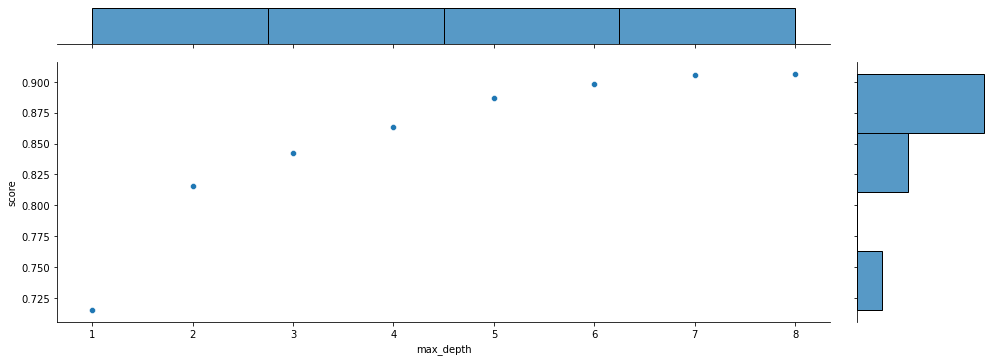

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='roc_auc', verbose=2)

In [39]:
tm.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'max_depth' : [i+1 for i in range(8)]},
                   x=train_X_pca,
                   y=train_y_pca)

2. min_samples_split

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters: {'min_samples_split': 0.006061000000000001}
The best score: 0.9154355951398175


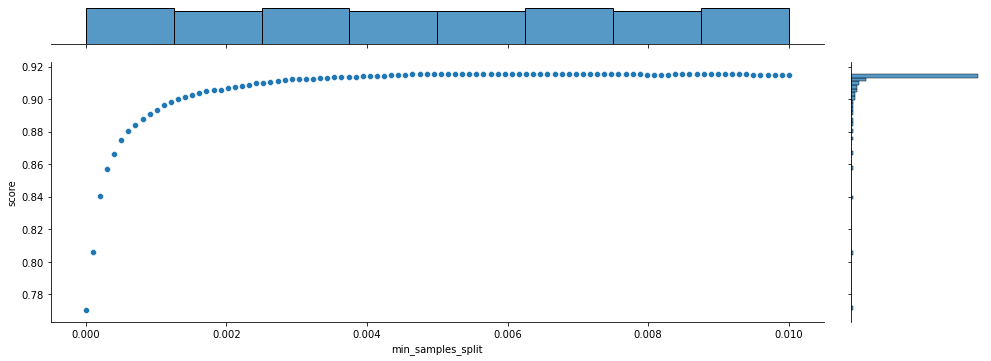

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'min_samples_split': array([1.000e-06, 1.020e-04, 2.030e-04, 3.040e-04, 4.050e-04, 5.060e-04,
       6.070e-04, 7.080e-04, 8.090e-04, 9.100e-04, 1.011e-03, 1.112e-03,
       1.213e-03, 1.314e-03, 1.415e-03, 1.516e-03, 1.617e-03, 1.718e-03,
       1.819e-03, 1.920e-03, 2.021e-03, 2.122e-03, 2.223e-03, 2.324e-03,
       2.425e-03...
       6.667e-03, 6.768e-03, 6.869e-03, 6.970e-03, 7.071e-03, 7.172e-03,
       7.273e-03, 7.374e-03, 7.475e-03, 7.576e-03, 7.677e-03, 7.778e-03,
       7.879e-03, 7.980e-03, 8.081e-03, 8.182e-03, 8.283e-03, 8.384e-03,
       8.485e-03, 8.586e-03, 8.687e-03, 8.788e-03, 8.889e-03, 8.990e-03,
       9.091e-03, 9.192e-03, 9.293e-03, 9.394e-03, 9.495e-03, 9.596e-03,
       9.697e-03, 9.798e-03, 9.899e-03, 1.000e-02])},
             scoring='roc_auc', verbose=2)

In [40]:
tm.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'min_samples_split' : np.linspace(0.000001, 0.01, 100)},
                   x=train_X_pca,
                   y=train_y_pca)

3. min_samples_leaf

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters: {'min_samples_leaf': 0.0015160000000000002}
The best score: 0.9177498919808692


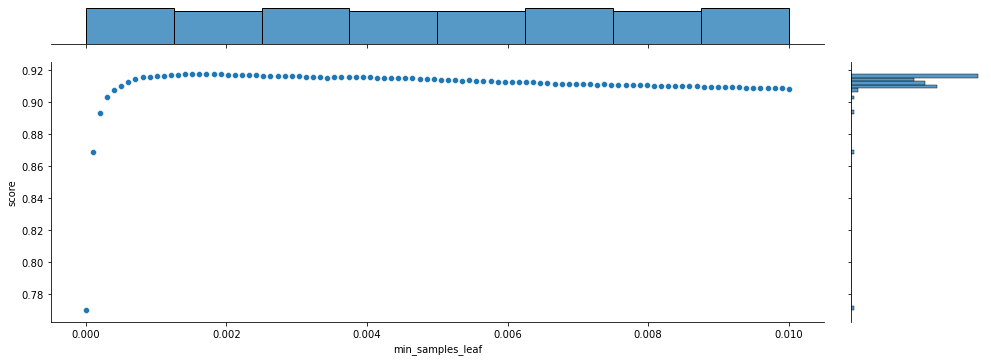

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'min_samples_leaf': array([1.000e-06, 1.020e-04, 2.030e-04, 3.040e-04, 4.050e-04, 5.060e-04,
       6.070e-04, 7.080e-04, 8.090e-04, 9.100e-04, 1.011e-03, 1.112e-03,
       1.213e-03, 1.314e-03, 1.415e-03, 1.516e-03, 1.617e-03, 1.718e-03,
       1.819e-03, 1.920e-03, 2.021e-03, 2.122e-03, 2.223e-03, 2.324e-03,
       2.425e-03,...
       6.667e-03, 6.768e-03, 6.869e-03, 6.970e-03, 7.071e-03, 7.172e-03,
       7.273e-03, 7.374e-03, 7.475e-03, 7.576e-03, 7.677e-03, 7.778e-03,
       7.879e-03, 7.980e-03, 8.081e-03, 8.182e-03, 8.283e-03, 8.384e-03,
       8.485e-03, 8.586e-03, 8.687e-03, 8.788e-03, 8.889e-03, 8.990e-03,
       9.091e-03, 9.192e-03, 9.293e-03, 9.394e-03, 9.495e-03, 9.596e-03,
       9.697e-03, 9.798e-03, 9.899e-03, 1.000e-02])},
             scoring='roc_auc', verbose=2)

In [41]:
tm.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'min_samples_leaf' : np.linspace(0.000001, 0.01, 100)},
                   x=train_X_pca,
                   y=train_y_pca)

4. max_leaf_nodes

Fitting 3 folds for each of 20 candidates, totalling 60 fits
The best parameters: {'max_leaf_nodes': 152}
The best score: 0.9129450324448068


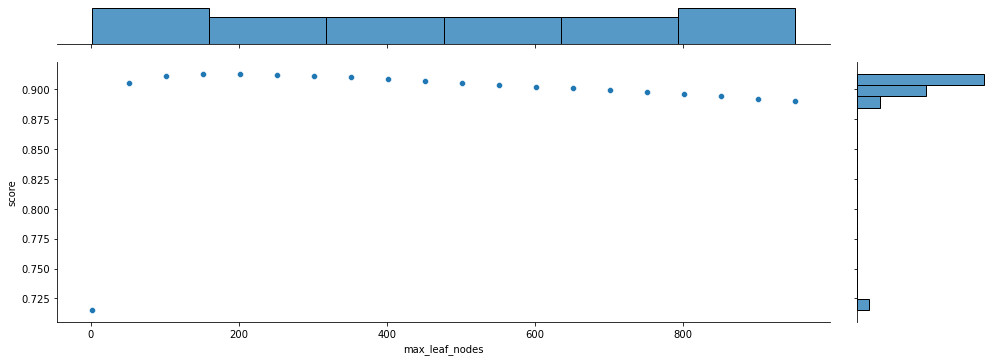

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'max_leaf_nodes': [2, 52, 102, 152, 202, 252, 302, 352,
                                            402, 452, 502, 552, 602, 652, 702,
                                            752, 802, 852, 902, 952]},
             scoring='roc_auc', verbose=2)

In [42]:
tm.evaluate_params(estimator=DecisionTreeClassifier(),
                   cv_method='grid',
                   param_grid={'max_leaf_nodes' : [i for i in range(2, 1000, 50)]},
                   x=train_X_pca,
                   y=train_y_pca)

# Random Forest Classifier - PCA Reduced

In [43]:
rfc = RandomForestClassifier()

In [44]:
param_grid_rfc = {'n_estimators' : stats.randint(600, 1000),
                  'max_depth' : [i for i in range(6, 9)],
                  'min_samples_split' : stats.uniform(0.004, 0.009),
                  'min_samples_leaf' : stats.uniform(0.0001, 0.005),
                  'max_leaf_nodes' : stats.randint(150, 250),
                  'max_features' : stats.randint(3, train_X_pca.shape[1] + 1)}

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters: {'max_depth': 8, 'max_features': 3, 'max_leaf_nodes': 224, 'min_samples_leaf': 0.0010658516513744824, 'min_samples_split': 0.0066432325316914615, 'n_estimators': 723}
The best score: 0.9207178169703708


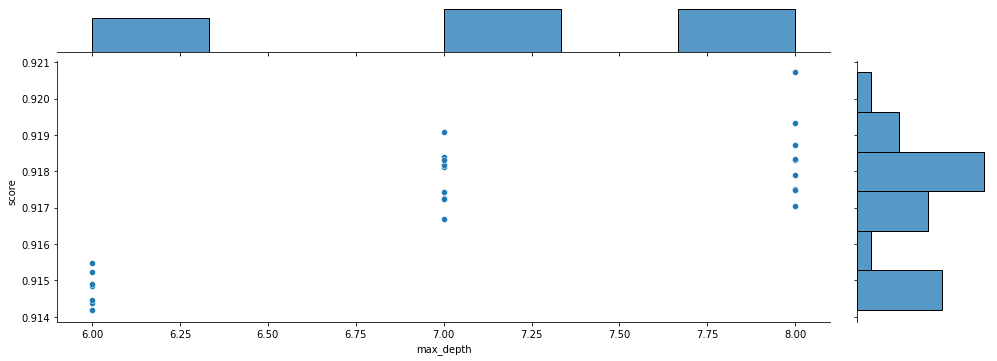

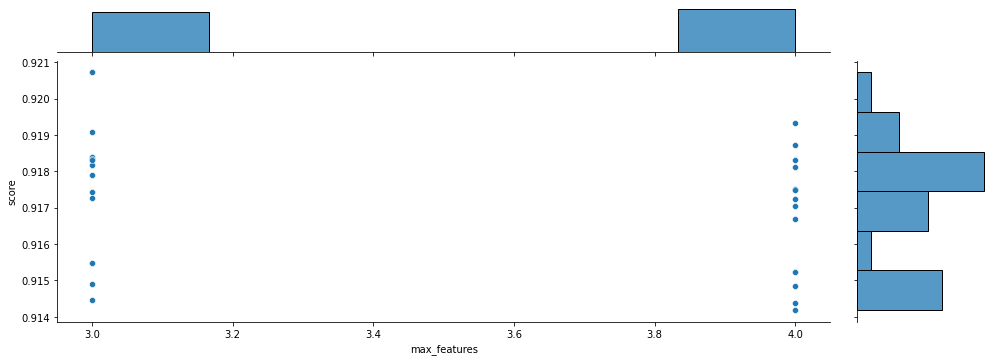

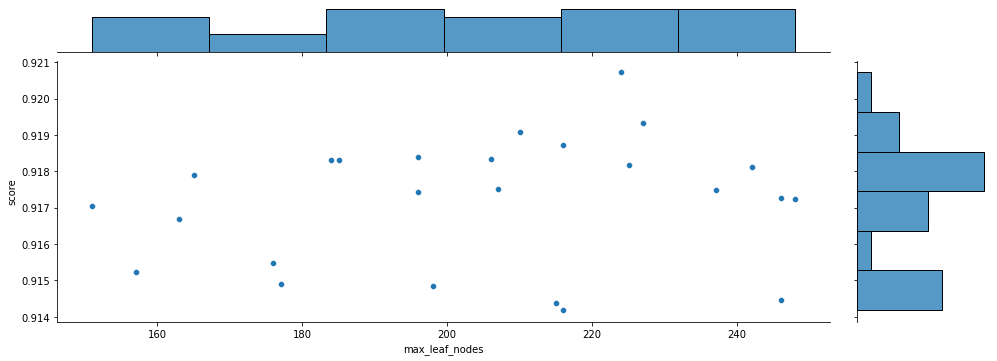

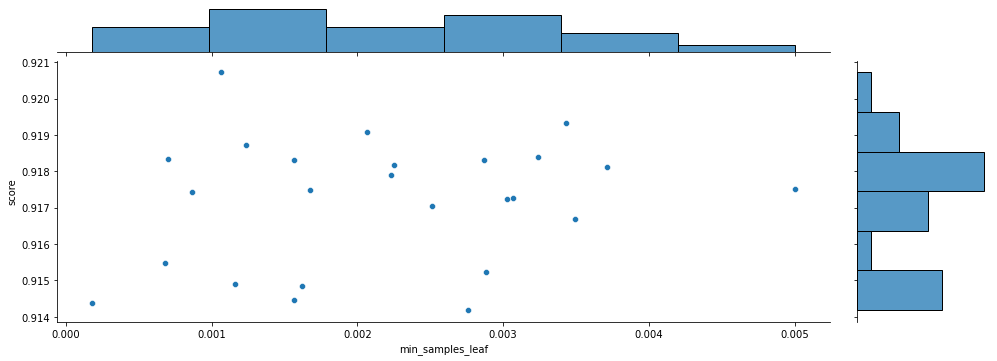

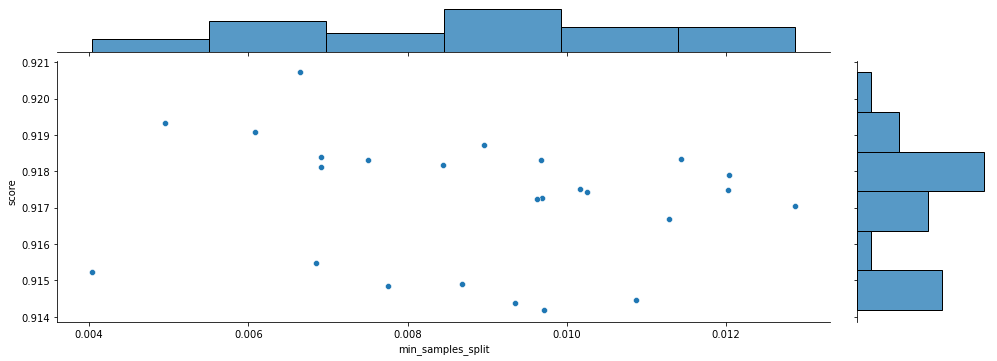

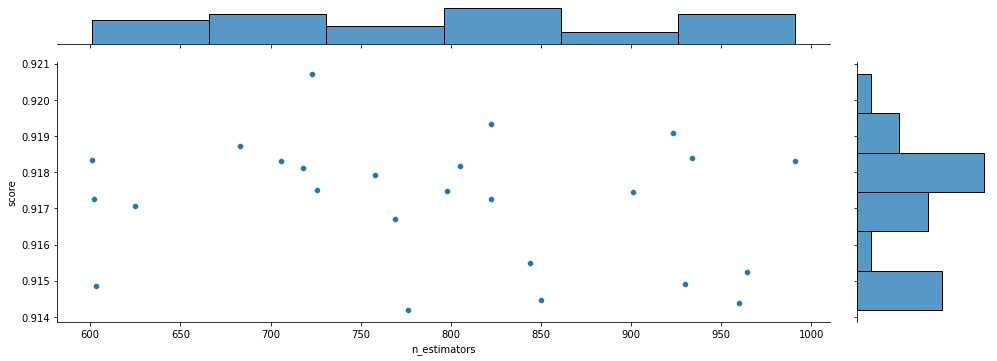

In [45]:
rfc_grid = tm.evaluate_params(estimator=rfc,
                              cv_method='randomized',
                              param_grid=param_grid_rfc,
                              x=train_X_pca,
                              y=train_y_pca,
                              cv=3,
                              scoring='roc_auc',
                              n_iter=25,
                              verbose=2,
                              n_jobs=6,
                              random_state=123)

# Random Forest Classifier - Final

In [46]:
# Using the best parameters
rfc_final = RandomForestClassifier(n_estimators = 800,
                                   criterion = 'gini',
                                   max_depth = 8,
                                   max_features = 4,
                                   max_leaf_nodes = 300,
                                   min_samples_leaf = 0.0035,
                                   min_samples_split = 0.006,
                                   verbose = False,
                                   random_state = 42,
                                   n_jobs = -1)

In [47]:
# Fit the training set
rfc_final.fit(train_X_pca, train_y_pca)

RandomForestClassifier(max_depth=8, max_features=4, max_leaf_nodes=300,
                       min_samples_leaf=0.0035, min_samples_split=0.006,
                       n_estimators=800, n_jobs=-1, random_state=42,
                       verbose=False)

In [48]:
# Predict on training set
train_y_pred_rfc = rfc_final.predict(train_X_pca)
train_y_prob_rfc = rfc_final.predict_proba(train_X_pca)

In [49]:
# Predict on test set
test_y_pred_rfc = rfc_final.predict(test_X_pca)
test_y_prob_rfc = rfc_final.predict_proba(test_X_pca)

In [67]:
print(confusion_matrix(test_y_pca, rfc_final.predict(test_X_pca) > 0.5))

[[17380  1333]
 [ 2170  5130]]


In [68]:
print(f1_score(test_y_pca, rfc_final.predict(test_X_pca) > 0.5))

0.7454770035602702


In [50]:
# ROC AUC Scores
print('ROC AUC - Train')
print(roc_auc_score(train_y_removed_outliers, train_y_prob_rfc[:,1]))
print('ROC AUC - Test')
print(roc_auc_score(test_y, test_y_prob_rfc[:,1]))

ROC AUC - Train
0.9224565508853997
ROC AUC - Test
0.9220258241102626


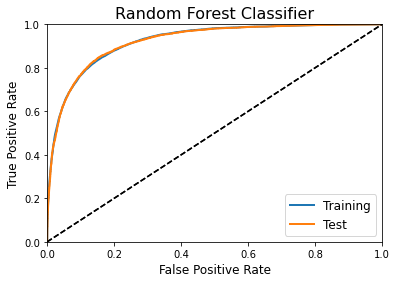

In [51]:
# ROC AUC curves
fpr_rfc_tr, tpr_rfc_tr, _ = roc_curve(train_y_removed_outliers, train_y_prob_rfc[:,1])
fpr_rfc_te, tpr_rfc_te, _ = roc_curve(test_y, test_y_prob_rfc[:,1])

vz.plot_roc_curve(fpr_rfc_tr, tpr_rfc_tr, "Training")
vz.plot_roc_curve(fpr_rfc_te, tpr_rfc_te, "Test")

plt.title('Random Forest Classifier', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# XGBoost

In [52]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(pipeline, train_X_pca, train_y_pca, scoring='roc_auc', cv=3, error_score='raise')

# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores))

3-fold AUC:  0.9296105493299902


# Neural Network 

In [53]:
from keras import Sequential
from keras.layers import Dense

In [55]:
nn = Sequential()

In [56]:
# First layer
nn.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
# Second layer
nn.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
# Output layer
nn.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [57]:
# Compile the neural network
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
# Fitting the data
nn.fit(train_X_pca, train_y_pca, batch_size=1000, epochs=100)

Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 0.6781 - accuracy: 0.7419
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.7713
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5347 - accuracy: 0.8142
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.8195
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.8208
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8235
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4086 - accuracy: 0.8287
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8349
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3723 - accuracy: 0.8419
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8484
Epoch 11/

99/99 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8695
Epoch 84/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8694
Epoch 85/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8693
Epoch 86/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8695
Epoch 87/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8694
Epoch 88/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8694
Epoch 89/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8693
Epoch 90/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8694
Epoch 91/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8691
Epoch 92/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8694
Epoch 93/100


In [59]:
# Evaluate the model on the training set
nn.evaluate(train_X_pca, train_y_pca)

3089/3089 [==============================] - 4s 1ms/step - loss: 0.3072 - accuracy: 0.8692


[0.30718597769737244, 0.8691930770874023]

In [60]:
print(confusion_matrix(test_y_pca, nn.predict(test_X_pca) > 0.5))

813/813 [==============================] - 1s 1ms/step
[[17432  1281]
 [ 2171  5129]]


In [69]:
print(f1_score(test_y_pca, nn.predict(test_X_pca) > 0.5))

813/813 [==============================] - 1s 1ms/step
0.7482129832239242


In [61]:
# Predict on training set
train_y_pred_nn = nn.predict(train_X_pca)
#tr_y_prob_nnc = nnc.predict_proba(tr_X_pca)
train_y_prob_nn =(nn.predict(train_X_pca) > 0.5).astype("int32")

3089/3089 [==============================] - 3s 1ms/step


In [62]:
# Predict on test set
test_y_pred_nn = nn.predict(test_X_pca)
#te_y_prob_nnc = nnc.predict_proba(te_X_pca)
test_y_prob_nn =(nn.predict(test_X_pca) > 0.5).astype("int32")

813/813 [==============================] - 1s 1ms/step


In [63]:
# ROC AUC Scores
print('ROC AUC - Train')
print(roc_auc_score(train_y_removed_outliers, train_y_prob_nn))
print('ROC AUC - Test')
print(roc_auc_score(test_y, test_y_prob_nn))

ROC AUC - Train
0.8022435463870788
ROC AUC - Test
0.8170738275127758


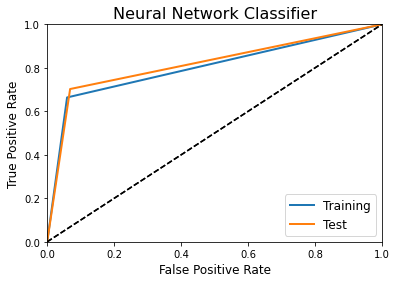

In [64]:
# ROC AUC curves
fpr_nn_tr, tpr_nn_tr, _ = roc_curve(train_y_removed_outliers, train_y_prob_nn)
fpr_nn_te, tpr_nn_te, _ = roc_curve(test_y, test_y_prob_nn)

vz.plot_roc_curve(fpr_nn_tr, tpr_nn_tr, "Training")
vz.plot_roc_curve(fpr_nn_te, tpr_nn_te, "Test")

plt.title('Neural Network Classifier', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()